# Triangular Lagrangian Second Order Elements 
The <b>goal</b> of this notebook is to implement second order Lagrange shape functions on triangular elements.

Remark
- the reference element for quadrature has vertices $(\xi_1,\eta_1) = (0,0)$, $(\xi_2,\eta_2) =(1,0)$ and $(\xi_3,\eta_3) = (0,1)$; 

This notebook is structured as follows: 

## To do 

1. Document analytical reference results;
2. Documenty this notebook better; 
3. Use static arrays to define the identity matrix; 
4. Replace quadrature from [MinFEM.jl](https://github.com/MinFEM/MinFEM.jl/blob/b2640edd547c598a7d6f1779771a93372e0393a6/src/mesh.jl) by [Integrals.jl](https://github.com/SciML/Integrals.jl); 
5. improve plot of the quadrature points;  
6. plotting the shape function over triangular elements. See e.g. [this website](https://discourse.julialang.org/t/ternary-diagrams-and-surfaces-on-non-rectangular-grids/43423) or [this website](https://lruepke.github.io/FEM_lecture/lecture4/fem_in_2d.html);  

## Import Packages

In [11]:
using LinearAlgebra
using FastGaussQuadrature
using Plots
using SparseArrays
using BenchmarkTools 
using Test

In [12]:
include("quadrature.jl")

compute_weights_triangle

## Section 1:/ Introduction 

In [13]:
# from https://github.com/MinFEM/MinFEM.jl/blob/b2640edd547c598a7d6f1779771a93372e0393a6/src/mesh.jl 
function area_triangle(x1,x2,x3)
    l3 = norm(x1-x2)
    l2 = norm(x1-x3)
    l1 = norm(x2-x3)

    lc = 0.5 * (l1+l2+l3)
    area = sqrt(lc*(lc-l1)*(lc-l2)*(lc-l3))
    
    return area
end 

area_triangle (generic function with 1 method)

In [14]:
x1 = [0,0]; x2 = [2,0]; x3 = [0,2];
area = area_triangle(x1,x2,x3) 

1.9999999999999991

## Section 2:/ Verification using Linear Shape Functions 

In [39]:
# polynomial degree to FE approximation  
pdegree = 1;
# degree of numerical quadrature 
qorder = 6; 
xi = compute_coordinates_triangle(qorder)
w  = compute_weights_triangle(qorder)
display(xi)
display(w)

16-element Vector{Vector{Float64}}:
 [0.06943184420297371, 0.06461106321354769]
 [0.06943184420297371, 0.30709631153115907]
 [0.06943184420297371, 0.6234718442658671]
 [0.06943184420297371, 0.8659570925834785]
 [0.33000947820757187, 0.046518677526560935]
 [0.33000947820757187, 0.22110322250073802]
 [0.33000947820757187, 0.44888729929169013]
 [0.33000947820757187, 0.6234718442658671]
 [0.6699905217924281, 0.02291316667641278]
 [0.6699905217924281, 0.10890625570683385]
 [0.6699905217924281, 0.22110322250073802]
 [0.6699905217924281, 0.30709631153115907]
 [0.9305681557970262, 0.004820780989426014]
 [0.9305681557970262, 0.02291316667641278]
 [0.9305681557970262, 0.046518677526560935]
 [0.9305681557970262, 0.06461106321354769]

16-element Vector{Float64}:
 0.02815038307692565
 0.0527752773542295
 0.0527752773542295
 0.02815038307692565
 0.03799714764795021
 0.0712356204997401
 0.0712356204997401
 0.03799714764795021
 0.018715815315012756
 0.0350877052529335
 0.0350877052529335
 0.018715815315012756
 0.0021003652444748482
 0.003937685608733464
 0.003937685608733464
 0.0021003652444748482

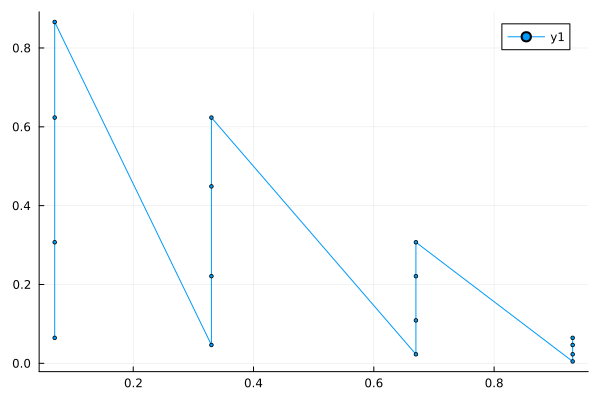

In [40]:
xxi = [xi1[1] for xi1 in xi]
yxi = [xi1[2] for xi1 in xi]
plot(xxi, yxi,marker=2)
# display(xxi)
# display(yxi)

In [41]:
# computation of the coefficients of the basis functions 
x = [[0.,0.], [1.,0], [0.,1.]]
X = [[x1[1], x1[2], 1] for x1 in x]
X = reduce(vcat,transpose(X))
I = [1. 0 0; 0 1. 0; 0 0 1.]; 
Emat = X\UniformScaling(1.)

3×3 Matrix{Float64}:
 -1.0  1.0  0.0
 -1.0  0.0  1.0
  1.0  0.0  0.0

In [42]:
# set coordinates of physical point 
# x1 = [0.,0.]; x2 = [2.,0.]; x3 = [0.,2.];  
x1 = [0.,0.]; x2 = [1.,0.]; x3 = [0.,1.];  
T = zeros(2,2); T[:,1] = x2 - x1; T[:,2] = x3 - x1; 
# vector of quadrature points on the physical finite element 
xs = [T*xi1+x1 for xi1 in xi];
# Vandermonde Matrix for evaluation of the basis functions
Xs = zeros(length(w),3);   
Xs = [[xs1[1], xs1[2], 1] for xs1 in xs];
Xs = reduce(vcat,transpose(Xs))
# Vandermonde Matrix for evaluation of the x/y derivatives of basis functions
dxXs = zeros(length(w),3);
dxXs = [[1, 0, 0] for xs1 in xs];
dxXs = reduce(vcat,transpose(dxXs))
dyXs = zeros(length(w),3);
dyXs = [[0, 1, 0] for xs1 in xs];
dyXs = reduce(vcat,transpose(dyXs))
display(dxXs)

16×3 Matrix{Int64}:
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0

In [43]:
display(Xs)
display(Emat)

16×3 Matrix{Float64}:
 0.0694318  0.0646111   1.0
 0.0694318  0.307096    1.0
 0.0694318  0.623472    1.0
 0.0694318  0.865957    1.0
 0.330009   0.0465187   1.0
 0.330009   0.221103    1.0
 0.330009   0.448887    1.0
 0.330009   0.623472    1.0
 0.669991   0.0229132   1.0
 0.669991   0.108906    1.0
 0.669991   0.221103    1.0
 0.669991   0.307096    1.0
 0.930568   0.00482078  1.0
 0.930568   0.0229132   1.0
 0.930568   0.0465187   1.0
 0.930568   0.0646111   1.0

3×3 Matrix{Float64}:
 -1.0  1.0  0.0
 -1.0  0.0  1.0
  1.0  0.0  0.0

In [44]:
# column basis and derivative of the basis vectors  
Phi   = Xs*Emat; 
dxPhi = dxXs*Emat; 
dyPhi = dyXs*Emat; 
display(Phi)

16×3 Matrix{Float64}:
 0.865957    0.0694318  0.0646111
 0.623472    0.0694318  0.307096
 0.307096    0.0694318  0.623472
 0.0646111   0.0694318  0.865957
 0.623472    0.330009   0.0465187
 0.448887    0.330009   0.221103
 0.221103    0.330009   0.448887
 0.0465187   0.330009   0.623472
 0.307096    0.669991   0.0229132
 0.221103    0.669991   0.108906
 0.108906    0.669991   0.221103
 0.0229132   0.669991   0.307096
 0.0646111   0.930568   0.00482078
 0.0465187   0.930568   0.0229132
 0.0229132   0.930568   0.0465187
 0.00482078  0.930568   0.0646111

In [45]:
# test whether basis function form a partition of unity   
vv = ones(3);
partionUnity = Phi * vv; 
@test partionUnity ≈ ones(length(w))

Test Passed

In [46]:
PhiPhi = zeros(length(w),9);
[PhiPhi[:,(j-1)*3+i] = Phi[:,i].*Phi[:,j] for i=1:3,j=1:3];
dxPhidxPhi = zeros(length(w),9);
[dxPhidxPhi[:,(j-1)*3+i] = dxPhi[:,i].*dxPhi[:,j] for i=1:3,j=1:3];
dyPhidyPhi = zeros(length(w),9);
[dyPhidyPhi[:,(j-1)*3+i] = dyPhi[:,i].*dyPhi[:,j] for i=1:3,j=1:3];
dPhidPhi = dxPhidxPhi + dyPhidyPhi; 
area = area_triangle(x1,x2,x3)
Mloc = 2*area*Transpose(w)*PhiPhi
Aloc = 2*area*Transpose(w)*dPhidPhi
display(PhiPhi)
display(reshape(Mloc,3,3))
display(reshape(Aloc,3,3))

16×9 Matrix{Float64}:
 0.749882     0.060125    0.0559504    0.060125    …  0.00448607  0.00417459
 0.388717     0.0432888   0.191466     0.0432888      0.0213223   0.0943081
 0.0943081    0.0213223   0.191466     0.0213223      0.0432888   0.388717
 0.00417459   0.00448607  0.0559504    0.00448607     0.060125    0.749882
 0.388717     0.205752    0.0290031    0.205752       0.0153516   0.00216399
 0.2015       0.148137    0.0992504    0.148137    …  0.0729662   0.0488866
 0.0488866    0.0729662   0.0992504    0.0729662      0.148137    0.2015
 0.00216399   0.0153516   0.0290031    0.0153516      0.205752    0.388717
 0.0943081    0.205752    0.00703655   0.205752       0.0153516   0.000525013
 0.0488866    0.148137    0.0240795    0.148137       0.0729662   0.0118606
 0.0118606    0.0729662   0.0240795    0.0729662   …  0.148137    0.0488866
 0.000525013  0.0153516   0.00703655   0.0153516      0.205752    0.0943081
 0.00417459   0.060125    0.000311476  0.060125       0.00448607  2.

3×3 reshape(transpose(::Vector{Float64}), 3, 3) with eltype Float64:
 0.0833333  0.0416667  0.0416667
 0.0416667  0.0833333  0.0416667
 0.0416667  0.0416667  0.0833333

3×3 reshape(transpose(::Vector{Float64}), 3, 3) with eltype Float64:
  1.0  -0.5  -0.5
 -0.5   0.5   0.0
 -0.5   0.0   0.5

In [47]:
Emat[3,:] .= 0;
AlocRef = area*(transpose(Emat)*Emat);
MlocRef = area/3*[1 0 0; 0 1 0; 0 0 1];
display(AlocRef)

3×3 Matrix{Float64}:
  1.0  -0.5  -0.5
 -0.5   0.5   0.0
 -0.5   0.0   0.5

## Section 3:/ Quadratic Shape Functions 

In [48]:
# computation of the coefficients of the basis functions 
x = [[0.,0.], [1.,0], [0.,1.], [0.5,0.], [0.5,0.5], [0.,0.5]]
X = [[x1[1]^2, x1[2]^2, x1[1]*x1[2], x1[1], x1[2], 1] for x1 in x]
X = reduce(vcat,transpose(X))
Emat = X\UniformScaling(1.)

6×6 Matrix{Float64}:
  2.0   2.0   0.0  -4.0  0.0  -0.0
  2.0   0.0   2.0   0.0  0.0  -4.0
  4.0   0.0   0.0  -4.0  4.0  -4.0
 -3.0  -1.0   0.0   4.0  0.0   0.0
 -3.0   0.0  -1.0   0.0  0.0   4.0
  1.0   0.0   0.0   0.0  0.0   0.0

In [49]:
# set coordinates of physical point 
x1 = [0.,0.]; x2 = [2.,0.]; x3 = [0.,2.]; 
x12 = (x1+x2)/2; x23 = (x2+x3)/2; x13 = (x1+x3)/2; 
T = zeros(2,2); T[:,1] = x2 - x1; T[:,2] = x3 - x1; 
# vector of quadrature points on the physical finite element 
xs = [T*xi1+x1 for xi1 in xi];
# Vandermonde Matrix for evaluation of the basis functions
Xs = zeros(length(w),6);   
Xs = [[xs1[1]^2, xs1[2]^2, xs1[1]*xs1[2], xs1[1], xs1[2], 1] for xs1 in xs];
Xs = reduce(vcat,transpose(Xs))
# Vandermonde Matrix for evaluation of the x/y derivatives of basis functions
dxXs = zeros(length(w),6);
dxXs = [[2*xs1[1], 0 , xs1[2], 1, 0, 0] for xs1 in xs];
dxXs = reduce(vcat,transpose(dxXs))
dyXs = zeros(length(w),6);
dyXs = [[0, 2*xs1[2], xs1[1], 0, 1, 0] for xs1 in xs];
dyXs = reduce(vcat,transpose(dyXs))
display(dxXs)

16×6 Matrix{Float64}:
 0.277727  0.0  0.129222    1.0  0.0  0.0
 0.277727  0.0  0.614193    1.0  0.0  0.0
 0.277727  0.0  1.24694     1.0  0.0  0.0
 0.277727  0.0  1.73191     1.0  0.0  0.0
 1.32004   0.0  0.0930374   1.0  0.0  0.0
 1.32004   0.0  0.442206    1.0  0.0  0.0
 1.32004   0.0  0.897775    1.0  0.0  0.0
 1.32004   0.0  1.24694     1.0  0.0  0.0
 2.67996   0.0  0.0458263   1.0  0.0  0.0
 2.67996   0.0  0.217813    1.0  0.0  0.0
 2.67996   0.0  0.442206    1.0  0.0  0.0
 2.67996   0.0  0.614193    1.0  0.0  0.0
 3.72227   0.0  0.00964156  1.0  0.0  0.0
 3.72227   0.0  0.0458263   1.0  0.0  0.0
 3.72227   0.0  0.0930374   1.0  0.0  0.0
 3.72227   0.0  0.129222    1.0  0.0  0.0

In [50]:
# column basis and derivative of the basis vectors  
Phi   = Xs*Emat; 
dxPhi = dxXs*Emat; 
dyPhi = dyXs*Emat; 
display(Phi)

16×6 Matrix{Float64}:
  0.339483  -0.100297  -0.0958254    0.406545  0.071777   0.378318
 -0.124981  -0.100297   0.140273     0.137166  0.341156   0.606684
  0.683502  -0.100297   1.86279     -0.214299  0.692621  -1.92432
  2.38729   -0.100297   4.26714     -0.483678  0.962     -6.03245
 -0.124981   0.211231  -0.0757255    0.65195   0.245626   0.0919
  0.123125   0.211231  -0.0511134   -0.269883  1.16746   -0.180819
  1.18006    0.211231   0.714224    -1.47262   2.37019   -2.00309
  2.55213    0.211231   1.86279     -2.39445   3.29203   -4.52373
  0.683502   2.25112   -0.0416262   -2.0679    0.245626  -0.0707205
  1.18006    2.25112   -0.122928    -2.98973   1.16746   -0.485978
  2.00582    2.25112   -0.0511134   -4.19247   2.37019   -1.38355
  2.77507    2.25112    0.140273    -5.1143    3.29203   -2.34419
  2.38729    5.06652   -0.00945564  -6.48255   0.071777  -0.0335826
  2.55213    5.06652   -0.0416262   -6.75192   0.341156  -0.166251
  2.77507    5.06652   -0.0757255   -7.10339  

In [51]:
# test whether basis function form a partition of unity   
vv = ones(6);
partionUnity = Phi * vv; 
@test partionUnity ≈ ones(length(w))

Test Passed

In [52]:
PhiPhi = zeros(length(w),36);
[PhiPhi[:,(j-1)*6+i] = Phi[:,i].*Phi[:,j] for i=1:6,j=1:6];
dxPhidxPhi = zeros(length(w),36);
[dxPhidxPhi[:,(j-1)*6+i] = dxPhi[:,i].*dxPhi[:,j] for i=1:6,j=1:6];
dyPhidyPhi = zeros(length(w),36);
[dyPhidyPhi[:,(j-1)*6+i] = dyPhi[:,i].*dyPhi[:,j] for i=1:6,j=1:6];
dPhidPhi = dxPhidxPhi + dyPhidyPhi; 
area = area_triangle(x1,x2,x3)
Mloc = 2*area*Transpose(w)*PhiPhi
Aloc = 2*area*Transpose(w)*dPhidPhi
display(reshape(Mloc,6,6))
display(reshape(Aloc,6,6))

6×6 reshape(transpose(::Vector{Float64}), 6, 6) with eltype Float64:
  3.86667   2.35556     2.35556    -5.33333   4.08889  -5.33333
  2.35556   3.46667    -0.0444444  -5.33333   2.13333  -1.24444
  2.35556  -0.0444444   3.46667    -1.24444   2.13333  -5.33333
 -5.33333  -5.33333    -1.24444     9.95556  -5.68889   4.97778
  4.08889   2.13333     2.13333    -5.68889   5.68889  -5.68889
 -5.33333  -1.24444    -5.33333     4.97778  -5.68889   9.95556

6×6 reshape(transpose(::Vector{Float64}), 6, 6) with eltype Float64:
  36.0      11.3333    11.3333   -45.3333    32.0      -45.3333
  11.3333   12.6667     0.0      -24.0        5.33333   -5.33333
  11.3333    0.0       12.6667    -5.33333    5.33333  -24.0
 -45.3333  -24.0       -5.33333   74.6667   -42.6667    42.6667
  32.0       5.33333    5.33333  -42.6667    42.6667   -42.6667
 -45.3333   -5.33333  -24.0       42.6667   -42.6667    74.6667